# Setup

In [ ]:
%pip install torch-geometric

In [1]:
import os
import math
import time
import psutil
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader

from sklearn.linear_model import Ridge

In [2]:
random_seed = 42

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(random_seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

using cpu


In [3]:
def compute_path_lengths(data):
    longest_path = 0
    shortest_path = float('inf')
    average_paths = []

    # Check if the data is a single graph or a dataset of graphs
    if isinstance(data, list) or isinstance(data, DataLoader):
        graphs = data
    else:
        graphs = [data]

    for graph in graphs:
        G = to_networkx(graph, to_undirected=True)
        
        # Compute shortest path lengths
        path_lengths = dict(nx.all_pairs_shortest_path_length(G))
        graph_longest_path = 0
        graph_total_path_length = 0
        graph_total_paths = 0
        
        for lengths in path_lengths.values():
            for length in lengths.values():
                if length > graph_longest_path:
                    graph_longest_path = length
                if length < shortest_path:
                    shortest_path = length
                graph_total_path_length += length
                graph_total_paths += 1

        # Update the overall longest path
        if graph_longest_path > longest_path:
            longest_path = graph_longest_path

        # Calculate the average path length for this graph
        if graph_total_paths > 0:
            graph_average_path = graph_total_path_length / graph_total_paths
            average_paths.append(graph_average_path)
    
    overall_average_path = np.mean(average_paths) if average_paths else 0
    std_average_path = np.std(average_paths) if average_paths else 0
    shortest_path = shortest_path if shortest_path != float('inf') else 0
    
    return int(longest_path), int(shortest_path), overall_average_path, std_average_path


# Graph Classification

In [4]:
# Load the MUTAG dataset
mutag_data = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# Split the dataset into train and test sets
mutag_train_dataset = mutag_data[:150]
mutag_test_dataset = mutag_data[150:]

# Create data loaders
mutag_train_loader = DataLoader(mutag_train_dataset, batch_size=32, shuffle=True)
mutag_test_loader = DataLoader(mutag_test_dataset, batch_size=32, shuffle=False)

# Get the number of features and classes from the dataset
num_features = mutag_train_dataset.num_features
num_classes = mutag_test_dataset.num_classes

In [5]:
# Compute path lengths for the train loader
longest_path, shortest_path, overall_average_path, std_average_path = compute_path_lengths(mutag_train_loader)
print(f'MUTAG dataset - Longest path: {longest_path}')
print(f'MUTAG dataset - Shortest path: {shortest_path}')
print(f'MUTAG dataset - Overall average path: {overall_average_path:.2f}')
print(f'MUTAG dataset - Standard deviation of average paths: {std_average_path:.2f}')

MUTAG dataset - Longest path: 15
MUTAG dataset - Shortest path: 0
MUTAG dataset - Overall average path: 3.64
MUTAG dataset - Standard deviation of average paths: 0.14


## Model Definition

### Models

#### GCN

In [30]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, 64)
        self.gcn2 = GCN(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### GCESN

In [5]:
class GCESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN_var1, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(adj, torch.mm(h, self.W)))
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [24]:
class GCESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN_var2, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(x, self.W) + torch.mm(adj, torch.mm(h, self.W)))
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### GCN-ESN

In [27]:
class GCNESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var1, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        n_node, _ = x.shape 
        state = torch.zeros(n_node, self.hidden_features)
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))

        x = global_mean_pool(state, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [28]:
class GCNESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var2, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        n_node, _ = x.shape 
        state = torch.zeros(n_node, self.hidden_features)
        
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        x = F.relu(self.gcn2(state, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        
        x = global_mean_pool(state, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Utilities

In [33]:
def train_graph(model, loader, lr=0.001, num_epochs=100, save_path='models/gcn_x.pth'):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []    
    
    # Train and test the models
    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()
        
        for data in loader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)  # Convert edge_index to adjacency matrix

            optimizer.zero_grad() 
            output = model(x, adj_matrix, batch)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs
    
        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')
        

    # Plot the training loss
    plt.plot(training_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage = np.mean(cpu_usage)
    avg_memory_usage = np.mean(memory_usage)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage = np.max(cpu_usage)
    max_memory_usage = np.max(memory_usage)


    print(f'Average Time per Epoch: {avg_epoch_time:.2f}s')
    print(f'Average CPU Usage: {avg_cpu_usage:.2f}GB')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')

    print(f'\nTotal Training Time: {total_training_time:.2f}s')
    print(f'Max CPU Usage: {max_cpu_usage:.2f}GB')
    print(f'Max Memory Usage: {max_memory_usage:.2f}GB')

    return training_loss[-1], total_training_time, avg_cpu_usage, avg_memory_usage, max_cpu_usage, max_memory_usage 

def evaluate(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    
    return accuracy, sensitivity, specificity
    
def test_graph(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x, data.edge_index, data.batch
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate(y_true, y_pred)
    # return accuracy, sensitivity, specificity
    return

In [17]:
def train_and_evaluate_multiple_runs_graph(model, data_loader, num_runs=50, num_epochs=500, path='models/multiple_run/gcesn_v1_graph_'):
    all_accuracies = []
    all_sensitivities = []
    all_specificities = []
    all_training_times = []
    all_avg_cpu_usages = []
    all_avg_memory_usages = []
    all_max_cpu_usages = []
    all_max_memory_usages = []

    for run in range(num_runs):
        # Train the model
        save_path = path + f'_run{run}.pth'
        loss, training_time, avg_cpu, avg_memory, max_cpu, max_memory = train_graph(model, data_loader, lr=0.01, num_epochs=num_epochs, save_path=save_path)
        
        # Test the model
        accuracy, sensitivity, specificity = test_graph(model, mutag_test_loader)

        # Store results
        all_accuracies.append(accuracy)
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)
        all_training_times.append(training_time)
        all_avg_cpu_usages.append(avg_cpu)
        all_avg_memory_usages.append(avg_memory)
        all_max_cpu_usages.append(max_cpu)
        all_max_memory_usages.append(max_memory)

        print(f'\nRun {run+1}/{num_runs} -> Loss: {loss}')
        print(f'  Total Training Time: {training_time:.2f}s, Avg CPU Usage: {avg_cpu:.2f}GB, Avg Memory Usage: {avg_memory:.2f}GB, Max CPU Usage: {max_cpu:.2f}GB, Max Memory Usage: {max_memory:.2f}GB')
        print(f'  Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')

    # Compute average values across all runs
    avg_accuracy = np.mean(all_accuracies)
    avg_sensitivity = np.mean(all_sensitivities)
    avg_specificity = np.mean(all_specificities)
    avg_training_time = np.mean(all_training_times)
    avg_cpu_usage = np.mean(all_avg_cpu_usages)
    avg_memory_usage = np.mean(all_avg_memory_usages)
    avg_max_cpu_usage = np.mean(all_max_cpu_usages)
    avg_max_memory_usage = np.mean(all_max_memory_usages)

    print('Overall Results:')
    print(f'  Avg Accuracy: {avg_accuracy:.4f}, Avg Sensitivity: {avg_sensitivity:.4f}, Avg Specificity: {avg_specificity:.4f}')
    print(f'  Avg Training Time: {avg_training_time:.2f}s, Avg CPU Usage: {avg_cpu_usage:.2f}GB, Avg Memory Usage: {avg_memory_usage:.2f}GB, Avg Max CPU Usage: {avg_max_cpu_usage:.2f}GB, Avg Max Memory Usage: {avg_max_memory_usage:.2f}GB')

## Training

### GCN

#### GCN 1-Layer

GCN1Layer(
  (gcn1): GCN (7 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 1284

Epoch 1, Loss: 96.71396768093109
Time: 0.12s, CPU: 1.58GB, Memory: 2.67GB
Epoch 2, Loss: 93.50504410266876
Time: 0.01s, CPU: 1.00GB, Memory: 2.66GB
Epoch 3, Loss: 91.8419896364212
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 4, Loss: 90.46569216251373
Time: 0.01s, CPU: 2.66GB, Memory: 2.66GB
Epoch 5, Loss: 88.50702345371246
Time: 0.01s, CPU: 2.66GB, Memory: 2.66GB
Epoch 6, Loss: 86.38542366027832
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 7, Loss: 84.17258870601654
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 8, Loss: 81.81487572193146
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 9, Loss: 79.72315526008606
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 10, Loss: 78.13580918312073
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 11, Loss: 76.90047818422318
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 12, Loss: 76.11045837402344
Time: 0.01s,

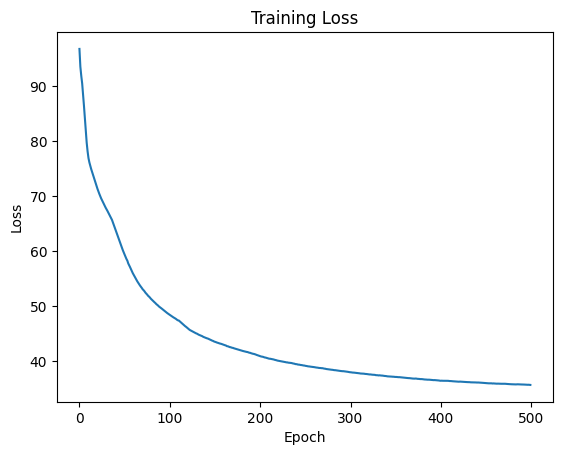

Model saved to models/gcn_1l_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.15GB
Average Memory Usage: 2.64GB

Total Training Time: 5.30s
Max CPU Usage: 4.45GB
Max Memory Usage: 2.67GB


In [12]:
# Create model instances
gcn1_graph = GCN1Layer(num_features, num_classes)
print(gcn1_graph)
print(f"Total number of trainable parameters: {(gcn1_graph.count_parameters())*2}\n")
train_graph(gcn1_graph, mutag_train_loader, lr=0.01, num_epochs=500, save_path='models/gcn_1l_graph.pth')

#### GCN 2-Layer

GCN2Layer(
  (gcn1): GCN (7 -> 64)
  (gcn2): GCN (64 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 9604

Epoch 1, Loss: 97.16585290431976
Time: 0.02s, CPU: 1.26GB, Memory: 2.66GB
Epoch 2, Loss: 91.46142411231995
Time: 0.01s, CPU: 1.60GB, Memory: 2.66GB
Epoch 3, Loss: 88.28254663944244
Time: 0.01s, CPU: 3.34GB, Memory: 2.66GB
Epoch 4, Loss: 84.55763399600983
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 5, Loss: 80.75717496871948
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 6, Loss: 76.53260433673859
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 7, Loss: 73.58288276195526
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 8, Loss: 72.83806717395782
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 9, Loss: 71.83973115682602
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 10, Loss: 70.6589081287384
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 11, Loss: 70.30955308675766
Time: 0.01s, CPU: 0.00GB, Memory: 2.66GB
Epoch 12, Loss: 69.35

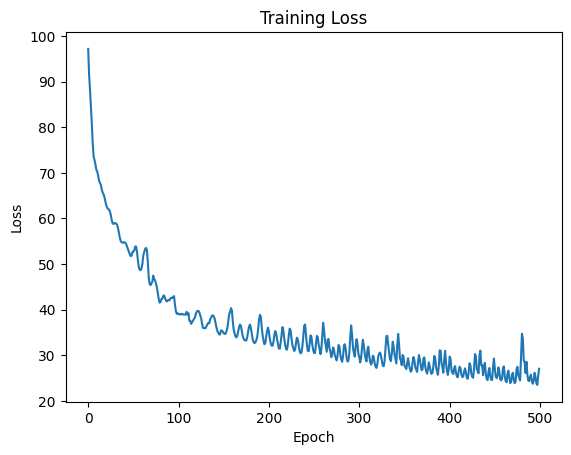

Model saved to models/gcn_2l_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.09GB
Average Memory Usage: 2.64GB

Total Training Time: 6.13s
Max CPU Usage: 3.34GB
Max Memory Usage: 2.66GB


In [13]:
gcn2_graph = GCN2Layer(num_features, num_classes)
print(gcn2_graph)
print(f"Total number of trainable parameters: {(gcn2_graph.count_parameters())*2}\n")
train_graph(gcn2_graph, mutag_train_loader, lr=0.01, num_epochs=500, save_path='models/gcn_2l_graph.pth')

### GCESN

#### Variant 1

GCESN_var1(
  (fc): Linear(in_features=7, out_features=2, bias=True)
)
Total number of trainable parameters: 16

Epoch 1, Loss: 4137.040214538574
Time: 0.02s, CPU: 0.35GB, Memory: 2.87GB
Epoch 2, Loss: 2271.0798625946045
Time: 0.01s, CPU: 2.40GB, Memory: 2.85GB
Epoch 3, Loss: 515.7592301368713
Time: 0.01s, CPU: 2.91GB, Memory: 2.86GB
Epoch 4, Loss: 353.1271777153015
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 5, Loss: 549.6270360946655
Time: 0.01s, CPU: 1.60GB, Memory: 2.86GB
Epoch 6, Loss: 559.0736780166626
Time: 0.01s, CPU: 2.40GB, Memory: 2.86GB
Epoch 7, Loss: 449.09347009658813
Time: 0.01s, CPU: 2.00GB, Memory: 2.86GB
Epoch 8, Loss: 261.768741607666
Time: 0.01s, CPU: 1.78GB, Memory: 2.86GB
Epoch 9, Loss: 133.8686192035675
Time: 0.01s, CPU: 2.66GB, Memory: 2.86GB
Epoch 10, Loss: 151.9594110250473
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 11, Loss: 126.52168536186218
Time: 0.01s, CPU: 0.00GB, Memory: 2.86GB
Epoch 12, Loss: 121.52104127407074
Time: 0.01s, CPU: 0.00GB, Memory: 

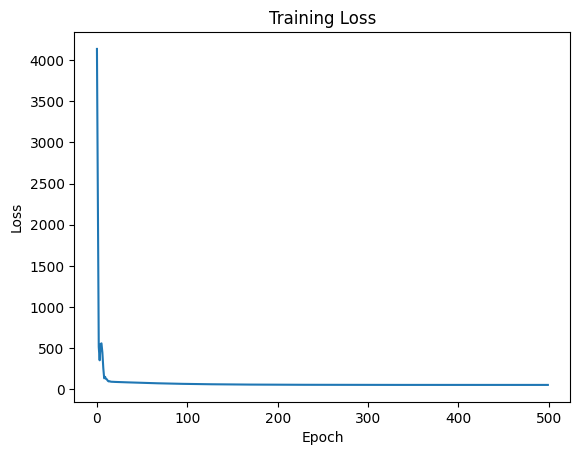

Model saved to models/gcesn_v1_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.14GB
Average Memory Usage: 2.84GB

Total Training Time: 5.05s
Max CPU Usage: 3.00GB
Max Memory Usage: 2.87GB


(53.79754090309143,
 5.054069519042969,
 0.14368,
 2.8428137817382813,
 3.0,
 2.87359619140625)

In [34]:
# Create model instances
gcesn1_graph = GCESN_var1(num_features, num_features, num_classes, num_iterations=6)
print(gcesn1_graph)
print(f"Total number of trainable parameters: {gcesn1_graph.count_parameters()}\n")
train_graph(gcesn1_graph, mutag_train_loader, lr=0.01, num_epochs=500, save_path='models/gcesn_v1_graph.pth')

In [22]:
# Create model instances
gcesn1_graph = GCESN_var1(num_features, num_features, num_classes, num_iterations=6)
train_and_evaluate_multiple_runs_graph(gcesn1_graph, mutag_train_loader, path='models/multiple_run/gcesn_v1_graph_')


Run 1/50 -> Loss: 53.95165282487869
  Total Training Time: 5.12s, Avg CPU Usage: 0.11GB, Avg Memory Usage: 2.89GB, Max CPU Usage: 2.91GB, Max Memory Usage: 2.95GB
  Accuracy: 0.7632, Sensitivity: 0.7692, Specificity: 0.7500

Run 2/50 -> Loss: 53.764961302280426
  Total Training Time: 4.89s, Avg CPU Usage: 0.12GB, Avg Memory Usage: 2.88GB, Max CPU Usage: 4.00GB, Max Memory Usage: 2.93GB
  Accuracy: 0.7632, Sensitivity: 0.7692, Specificity: 0.7500

Run 3/50 -> Loss: 53.73339545726776
  Total Training Time: 5.10s, Avg CPU Usage: 0.09GB, Avg Memory Usage: 2.89GB, Max CPU Usage: 3.06GB, Max Memory Usage: 2.95GB
  Accuracy: 0.7632, Sensitivity: 0.7692, Specificity: 0.7500

Run 4/50 -> Loss: 53.706200420856476
  Total Training Time: 5.22s, Avg CPU Usage: 0.11GB, Avg Memory Usage: 2.88GB, Max CPU Usage: 3.55GB, Max Memory Usage: 2.91GB
  Accuracy: 0.7632, Sensitivity: 0.7692, Specificity: 0.7500

Run 5/50 -> Loss: 53.67963665723801
  Total Training Time: 5.01s, Avg CPU Usage: 0.14GB, Avg Memo

#### Variant 2

GCESN_var2(
  (fc): Linear(in_features=7, out_features=2, bias=True)
)
Total number of trainable parameters: 16

Epoch 1, Loss: 2295.724142074585
Time: 0.01s, CPU: 0.78GB, Memory: 2.61GB
Epoch 2, Loss: 1418.399980545044
Time: 0.01s, CPU: 2.66GB, Memory: 2.61GB
Epoch 3, Loss: 555.2809453010559
Time: 0.01s, CPU: 1.78GB, Memory: 2.61GB
Epoch 4, Loss: 161.29593348503113
Time: 0.01s, CPU: 0.00GB, Memory: 2.61GB
Epoch 5, Loss: 294.56826543807983
Time: 0.01s, CPU: 2.40GB, Memory: 2.61GB
Epoch 6, Loss: 328.2090320587158
Time: 0.01s, CPU: 1.60GB, Memory: 2.61GB
Epoch 7, Loss: 281.4016981124878
Time: 0.01s, CPU: 0.00GB, Memory: 2.61GB
Epoch 8, Loss: 186.83308863639832
Time: 0.01s, CPU: 0.00GB, Memory: 2.61GB
Epoch 9, Loss: 124.0285906791687
Time: 0.01s, CPU: 0.00GB, Memory: 2.61GB
Epoch 10, Loss: 150.17348897457123
Time: 0.01s, CPU: 0.00GB, Memory: 2.61GB
Epoch 11, Loss: 114.30204427242279
Time: 0.01s, CPU: 0.00GB, Memory: 2.61GB
Epoch 12, Loss: 120.77315747737885
Time: 0.01s, CPU: 0.00GB, Memor

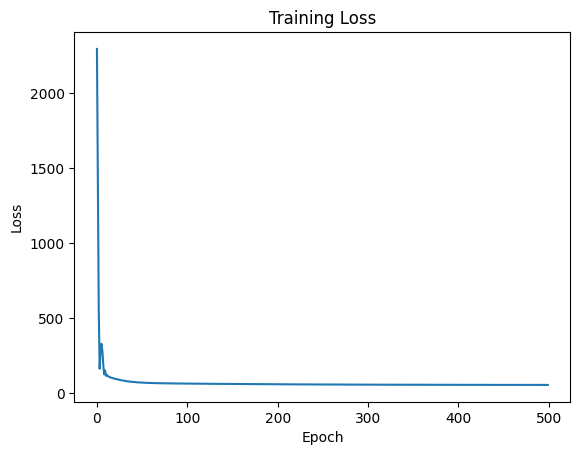

Model saved to models/gcesn_v2_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.10GB
Average Memory Usage: 2.64GB

Total Training Time: 5.27s
Max CPU Usage: 3.08GB
Max Memory Usage: 2.67GB


In [15]:
# Create model instances
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=6)
print(gcesn2_graph)
print(f"Total number of trainable parameters: {gcesn2_graph.count_parameters()}\n")
train_graph(gcesn2_graph, mutag_train_loader, lr=0.01, num_epochs=500, save_path='models/gcesn_v2_graph.pth')

In [25]:
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=6)
train_and_evaluate_multiple_runs_graph(gcesn2_graph, mutag_train_loader, path='models/multiple_run/gcesn_v2_graph_')


Run 1/50 -> Loss: 53.963662981987
  Total Training Time: 5.34s, Avg CPU Usage: 0.10GB, Avg Memory Usage: 2.77GB, Max CPU Usage: 4.40GB, Max Memory Usage: 2.81GB
  Accuracy: 0.7632, Sensitivity: 0.8462, Specificity: 0.5833

Run 2/50 -> Loss: 53.80921429395676
  Total Training Time: 5.26s, Avg CPU Usage: 0.10GB, Avg Memory Usage: 2.78GB, Max CPU Usage: 3.00GB, Max Memory Usage: 2.81GB
  Accuracy: 0.7895, Sensitivity: 0.8846, Specificity: 0.5833

Run 3/50 -> Loss: 53.545535147190094
  Total Training Time: 5.14s, Avg CPU Usage: 0.08GB, Avg Memory Usage: 2.77GB, Max CPU Usage: 3.20GB, Max Memory Usage: 2.77GB
  Accuracy: 0.8158, Sensitivity: 0.8846, Specificity: 0.6667

Run 4/50 -> Loss: 53.29936909675598
  Total Training Time: 5.37s, Avg CPU Usage: 0.11GB, Avg Memory Usage: 2.81GB, Max CPU Usage: 3.55GB, Max Memory Usage: 2.85GB
  Accuracy: 0.8158, Sensitivity: 0.8846, Specificity: 0.6667

Run 5/50 -> Loss: 53.07996082305908
  Total Training Time: 5.14s, Avg CPU Usage: 0.11GB, Avg Memory 

### GCN-ESN

#### Variant 1

GCNESN_var1(
  (gcn1): GCN (7 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 642

Epoch 1, Loss: 99.98311936855316
Time: 0.02s, CPU: 1.08GB, Memory: 2.63GB
Epoch 2, Loss: 92.90535962581635
Time: 0.01s, CPU: 1.78GB, Memory: 2.63GB
Epoch 3, Loss: 88.81871235370636
Time: 0.01s, CPU: 1.78GB, Memory: 2.63GB
Epoch 4, Loss: 84.03248465061188
Time: 0.01s, CPU: 2.40GB, Memory: 2.63GB
Epoch 5, Loss: 80.99719786643982
Time: 0.01s, CPU: 2.91GB, Memory: 2.63GB
Epoch 6, Loss: 77.82311314344406
Time: 0.01s, CPU: 2.00GB, Memory: 2.63GB
Epoch 7, Loss: 76.89420104026794
Time: 0.01s, CPU: 2.00GB, Memory: 2.63GB
Epoch 8, Loss: 75.37752503156662
Time: 0.01s, CPU: 2.18GB, Memory: 2.63GB
Epoch 9, Loss: 74.45977663993835
Time: 0.01s, CPU: 3.00GB, Memory: 2.63GB
Epoch 10, Loss: 72.87738102674484
Time: 0.01s, CPU: 2.00GB, Memory: 2.63GB
Epoch 11, Loss: 71.70406275987625
Time: 0.01s, CPU: 0.00GB, Memory: 2.63GB
Epoch 12, Loss: 70.55760860443115
Time: 0.01

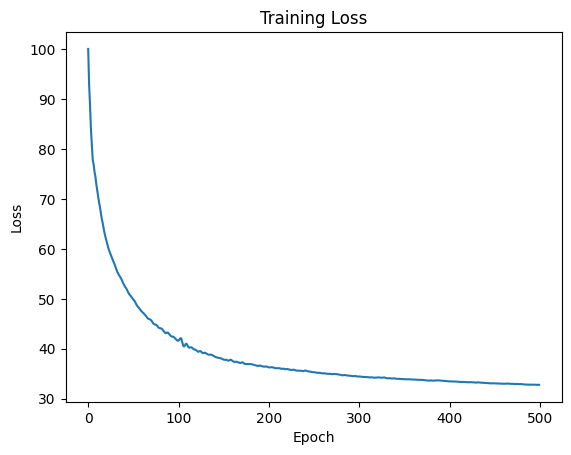

Model saved to models/gcnesn_v1_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.15GB
Average Memory Usage: 2.62GB

Total Training Time: 5.77s
Max CPU Usage: 3.43GB
Max Memory Usage: 2.65GB


In [16]:
# Create model instances
gcnesn1_graph = GCNESN_var1(num_features, 64, num_classes)
print(gcnesn1_graph)
print(f"Total number of trainable parameters: {gcnesn1_graph.count_parameters()}\n")
train_graph(gcnesn1_graph, mutag_train_loader, lr=0.01, num_epochs=500, save_path='models/gcnesn_v1_graph.pth')

In [31]:
# Create model instances
gcnesn1_graph = GCNESN_var1(num_features, 64, num_classes)
train_and_evaluate_multiple_runs_graph(gcnesn1_graph, mutag_train_loader, path='models/multiple_run/gcnesn_v1_graph_')


Run 1/50 -> Loss: 32.575501054525375
  Total Training Time: 6.11s, Avg CPU Usage: 0.14GB, Avg Memory Usage: 2.79GB, Max CPU Usage: 5.52GB, Max Memory Usage: 2.83GB
  Accuracy: 0.8421, Sensitivity: 0.8462, Specificity: 0.8333

Run 2/50 -> Loss: 31.48069801926613
  Total Training Time: 6.42s, Avg CPU Usage: 0.12GB, Avg Memory Usage: 2.81GB, Max CPU Usage: 3.34GB, Max Memory Usage: 2.89GB
  Accuracy: 0.8421, Sensitivity: 0.8462, Specificity: 0.8333

Run 3/50 -> Loss: 31.111954301595688
  Total Training Time: 6.28s, Avg CPU Usage: 0.12GB, Avg Memory Usage: 2.84GB, Max CPU Usage: 3.70GB, Max Memory Usage: 2.91GB
  Accuracy: 0.8421, Sensitivity: 0.8462, Specificity: 0.8333

Run 4/50 -> Loss: 30.840818285942078
  Total Training Time: 6.51s, Avg CPU Usage: 0.21GB, Avg Memory Usage: 2.77GB, Max CPU Usage: 4.50GB, Max Memory Usage: 2.80GB
  Accuracy: 0.8421, Sensitivity: 0.8462, Specificity: 0.8333

Run 5/50 -> Loss: 30.633679449558258
  Total Training Time: 6.13s, Avg CPU Usage: 0.12GB, Avg Me

#### Variant 2

GCNESN_var2(
  (gcn1): GCN (7 -> 64)
  (gcn2): GCN (64 -> 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)
Total number of trainable parameters: 4802

Epoch 1, Loss: 106.38254773616791
Time: 0.02s, CPU: 0.77GB, Memory: 2.62GB
Epoch 2, Loss: 89.93755304813385
Time: 0.02s, CPU: 1.85GB, Memory: 2.63GB
Epoch 3, Loss: 83.92934930324554
Time: 0.02s, CPU: 2.29GB, Memory: 2.63GB
Epoch 4, Loss: 79.37990772724152
Time: 0.01s, CPU: 2.18GB, Memory: 2.63GB
Epoch 5, Loss: 75.57724744081497
Time: 0.01s, CPU: 2.00GB, Memory: 2.63GB
Epoch 6, Loss: 73.92352396249771
Time: 0.01s, CPU: 0.80GB, Memory: 2.63GB
Epoch 7, Loss: 73.73195052146912
Time: 0.01s, CPU: 0.00GB, Memory: 2.63GB
Epoch 8, Loss: 74.6407681107521
Time: 0.01s, CPU: 0.00GB, Memory: 2.63GB
Epoch 9, Loss: 73.24888026714325
Time: 0.01s, CPU: 0.00GB, Memory: 2.63GB
Epoch 10, Loss: 71.09573745727539
Time: 0.01s, CPU: 0.00GB, Memory: 2.63GB
Epoch 11, Loss: 68.35286235809326
Time: 0.01s, CPU: 0.00GB, Memory: 2.63GB
Epoch 12, Loss: 67

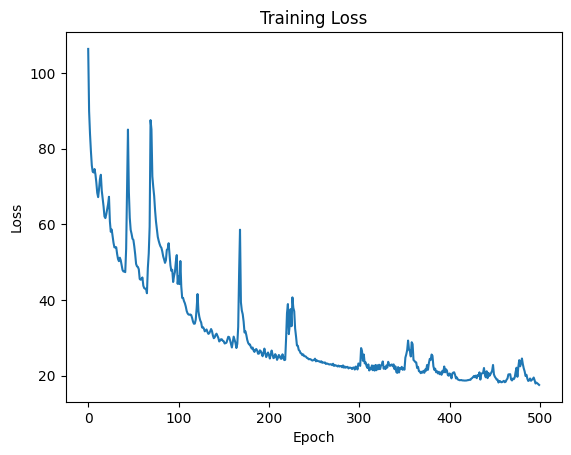

Model saved to models/gcnesn_v2_graph.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.18GB
Average Memory Usage: 2.58GB

Total Training Time: 7.27s
Max CPU Usage: 3.34GB
Max Memory Usage: 2.63GB


In [19]:
# Create model instances
gcnesn2_graph = GCNESN_var2(num_features, 64, num_classes)
print(gcnesn2_graph)
print(f"Total number of trainable parameters: {gcnesn2_graph.count_parameters()}\n")
train_graph(gcnesn2_graph, mutag_train_loader, lr=0.01, num_epochs=500, save_path='models/gcnesn_v2_graph.pth')

In [32]:
# Create model instances
gcnesn2_graph = GCNESN_var2(num_features, 64, num_classes)
train_and_evaluate_multiple_runs_graph(gcnesn2_graph, mutag_train_loader, path='models/multiple_run/gcnesn_v2_graph_')


Run 1/50 -> Loss: 39.399074733257294
  Total Training Time: 8.06s, Avg CPU Usage: 0.15GB, Avg Memory Usage: 2.81GB, Max CPU Usage: 4.50GB, Max Memory Usage: 2.83GB
  Accuracy: 0.7895, Sensitivity: 0.8077, Specificity: 0.7500

Run 2/50 -> Loss: 30.658544540405273
  Total Training Time: 8.42s, Avg CPU Usage: 0.23GB, Avg Memory Usage: 2.71GB, Max CPU Usage: 6.29GB, Max Memory Usage: 2.77GB
  Accuracy: 0.7632, Sensitivity: 0.8077, Specificity: 0.6667

Run 3/50 -> Loss: 19.202740013599396
  Total Training Time: 7.87s, Avg CPU Usage: 0.20GB, Avg Memory Usage: 2.74GB, Max CPU Usage: 4.00GB, Max Memory Usage: 2.77GB
  Accuracy: 0.7632, Sensitivity: 0.8462, Specificity: 0.5833

Run 4/50 -> Loss: 25.443185210227966
  Total Training Time: 8.01s, Avg CPU Usage: 0.16GB, Avg Memory Usage: 2.76GB, Max CPU Usage: 3.50GB, Max Memory Usage: 2.79GB
  Accuracy: 0.7105, Sensitivity: 0.8077, Specificity: 0.5000

Run 5/50 -> Loss: 19.085509926080704
  Total Training Time: 7.88s, Avg CPU Usage: 0.13GB, Avg M

## Evaluation

In [21]:
print('Model 1-Layer GCN')
gcn1_graph = GCN1Layer(num_features, num_classes)
gcn1_graph.load_state_dict(torch.load('models/gcn_1l_graph.pth'))
test_graph(gcn1_graph, mutag_test_loader)

print('\nModel 2-Layer GCN')
gcn2_graph = GCN2Layer(num_features, num_classes)
gcn2_graph.load_state_dict(torch.load('models/gcn_2l_graph.pth'))
test_graph(gcn2_graph, mutag_test_loader)

print('\nModel GCESN Var-1')
gcesn1_graph = GCESN_var1(num_features, num_features, num_classes, num_iterations=6)
gcesn1_graph.load_state_dict(torch.load('models/gcesn_v1_graph.pth'))
test_graph(gcesn1_graph, mutag_test_loader)

print('\nModel GCESN Var-2')
gcesn2_graph = GCESN_var2(num_features, num_features, num_classes, num_iterations=6)
gcesn2_graph.load_state_dict(torch.load('models/gcesn_v2_graph.pth'))
test_graph(gcesn2_graph, mutag_test_loader)

print('\nModel GCNESN Var-1')
gcnesn1_graph = GCNESN_var1(num_features, 64, num_classes)
gcnesn1_graph.load_state_dict(torch.load('models/gcnesn_v1_graph.pth'))
test_graph(gcnesn1_graph, mutag_test_loader)

print('\nModel GCNESN Var-2')
gcnesn2_graph = GCNESN_var2(num_features, 64, num_classes)
gcnesn2_graph.load_state_dict(torch.load('models/gcnesn_v2_graph.pth'))
test_graph(gcnesn2_graph, mutag_test_loader)

Model 1-Layer GCN
Accuracy: 0.7895
Sensitivity: 0.8077
Specificity: 0.7500

Model 2-Layer GCN
Accuracy: 0.8421
Sensitivity: 0.8462
Specificity: 0.8333

Model GCESN Var-1
Accuracy: 0.7632
Sensitivity: 0.7692
Specificity: 0.7500

Model GCESN Var-2
Accuracy: 0.7105
Sensitivity: 0.7692
Specificity: 0.5833

Model GCNESN Var-1
Accuracy: 0.8421
Sensitivity: 0.8462
Specificity: 0.8333

Model GCNESN Var-2
Accuracy: 0.8158
Sensitivity: 0.8462
Specificity: 0.7500


# Node Classification

In [22]:
# Load the Cora dataset
cora_dataset = Planetoid(root='/tmp/Cora', name='Cora')
cora_data = cora_dataset[0]

# Example of data attributes
print(cora_data)
print("Node feature shape:", cora_data.x.shape)
print("Edge index shape:", cora_data.edge_index.shape)
print("Number of classes:", cora_dataset.num_classes)
print("Number of node features:", cora_dataset.num_node_features)

# Splitting the data into train, validation, and test sets
train_mask = cora_data.train_mask
val_mask = cora_data.val_mask
test_mask = cora_data.test_mask


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Node feature shape: torch.Size([2708, 1433])
Edge index shape: torch.Size([2, 10556])
Number of classes: 7
Number of node features: 1433


In [23]:
longest_path, shortest_path, overall_average_path, std_average_path = compute_path_lengths(cora_data)
print(f'Cora dataset - Longest path: {longest_path}')
print(f'Cora dataset - Shortest path: {shortest_path}')
print(f'Cora dataset - Overall average path: {overall_average_path:.2f}')
print(f'Cora dataset - Standard deviation of average paths: {std_average_path:.2f}')

Cora dataset - Longest path: 19
Cora dataset - Shortest path: 0
Cora dataset - Overall average path: 6.31
Cora dataset - Standard deviation of average paths: 0.00


## Model Definition

### Models

#### GCN

In [24]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, adj):
        # print(f'x shape: {x.shape}, adj shape: {adj.shape}')
        x = F.relu(self.gcn1(x, adj))
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, 16)
        self.gcn2 = GCN(16, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, adj):
        x = F.relu(self.gcn1(x, adj))
        x = F.relu(self.gcn2(x, adj))
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### GCESN

In [25]:
class GCESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN_var1, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(adj, torch.mm(h, self.W)))
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [26]:
class GCESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, num_iterations=6):
        super(GCESN_var2, self).__init__()
        self.in_features = in_features
        self.reservoir_size = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.initialize_weights()
        
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.W = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj):
        h = x
        for _ in range(self.num_iterations):
            h = F.relu(torch.mm(x, self.W) + torch.mm(adj, torch.mm(h, self.W)))
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

#### GCN-ESN

In [31]:
class GCNESN_var1(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var1, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj):
        n_node, _ = x.shape 
        state = torch.zeros(n_node, self.hidden_features)
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))

        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [32]:
class GCNESN_var2(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes):
        super(GCNESN_var2, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.reservoir_size = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.initialize_weights()

        self.gcn1 = GCN(in_features, hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.reservoir_size, self.reservoir_size)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj):
        n_node, _ = x.shape 
        state = torch.zeros(n_node, self.hidden_features)
        
        x = F.relu(self.gcn1(x, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        x = F.relu(self.gcn2(state, adj))
        state = torch.tanh(torch.mm(x, self.Win) + torch.mm(state, self.W))
        
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### Utilities

In [29]:
def train_node(model, data, lr=0.001, num_epochs=100, save_path='models/gcn_x.pth'):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    training_loss = []
    epoch_time = []
    cpu_usage = []
    memory_usage = []    

    adj_matrix = utils.to_dense_adj(data.edge_index).squeeze(0)  # Convert edge_index to adjacency matrix
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        optimizer.zero_grad()
        output = model(data.x, adj_matrix)
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        epoch_loss = loss.item()

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        cpu_usage.append(psutil.cpu_percent(interval=None) / 100 * psutil.virtual_memory().total / (1024**3))  # CPU usage in GB
        memory_usage.append(psutil.virtual_memory().used / (1024**3))  # Memory usage in GB
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage[-1]:.2f}GB, Memory: {memory_usage[-1]:.2f}GB')

    # Plot the training loss
    plt.plot(training_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

    print(f'Average Time per Epoch: {np.mean(epoch_time):.2f}s')
    print(f'Average CPU Usage: {np.mean(cpu_usage):.2f}GB')
    print(f'Average Memory Usage: {np.mean(memory_usage):.2f}GB')

    print(f'\nTotal Training Time: {np.sum(epoch_time):.2f}s')
    print(f'Max CPU Usage: {np.max(cpu_usage):.2f}GB')
    print(f'Max Memory Usage: {np.max(memory_usage):.2f}GB')

    return 

def evaluate(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    
    return accuracy, sensitivity, specificity

def test_node(model, data, mask):
    model.eval()
    y_true = data.y[mask].tolist()
    y_pred = []

    with torch.no_grad():
        adj_matrix = utils.to_dense_adj(data.edge_index).squeeze(0)
        output = model(data.x, adj_matrix)
        pred = output[mask].argmax(dim=1)
        y_pred.extend(pred.tolist())

    accuracy, sensitivity, specificity = evaluate(y_true, y_pred)
    return 

## Training

### GCN

GCN1Layer(
  (gcn1): GCN (1433 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23063

Epoch 1, Loss: 2.389894962310791
Time: 0.02s, CPU: 0.70GB, Memory: 2.83GB
Epoch 2, Loss: 1.927914023399353
Time: 0.01s, CPU: 2.29GB, Memory: 2.83GB
Epoch 3, Loss: 1.7123347520828247
Time: 0.01s, CPU: 2.29GB, Memory: 2.82GB
Epoch 4, Loss: 1.574715256690979
Time: 0.01s, CPU: 1.34GB, Memory: 2.82GB
Epoch 5, Loss: 1.4654847383499146
Time: 0.01s, CPU: 2.00GB, Memory: 2.82GB
Epoch 6, Loss: 1.3687598705291748
Time: 0.01s, CPU: 0.00GB, Memory: 2.82GB
Epoch 7, Loss: 1.2797341346740723
Time: 0.01s, CPU: 0.00GB, Memory: 2.82GB
Epoch 8, Loss: 1.1930458545684814
Time: 0.01s, CPU: 0.00GB, Memory: 2.82GB
Epoch 9, Loss: 1.109560251235962
Time: 0.01s, CPU: 0.00GB, Memory: 2.82GB
Epoch 10, Loss: 1.0325015783309937
Time: 0.01s, CPU: 0.00GB, Memory: 2.82GB
Epoch 11, Loss: 0.9587035179138184
Time: 0.01s, CPU: 0.00GB, Memory: 2.82GB
Epoch 12, Loss: 0.8853389620780945

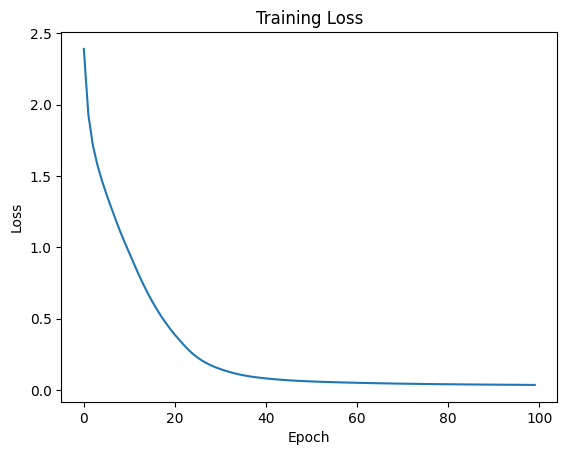

Model saved to models/gcn_1l_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.09GB
Average Memory Usage: 2.82GB

Total Training Time: 0.84s
Max CPU Usage: 2.29GB
Max Memory Usage: 2.83GB


In [22]:
# Create model instances
gcn1_node = GCN1Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
print(gcn1_node)
print(f"Total number of trainable parameters: {gcn1_node.count_parameters()}\n")
train_node(gcn1_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcn_1l_node.pth')


GCN2Layer(
  (gcn1): GCN (1433 -> 16)
  (gcn2): GCN (16 -> 16)
  (fc): Linear(in_features=16, out_features=7, bias=True)
)
Total number of trainable parameters: 23335

Epoch 1, Loss: 3.7939679622650146
Time: 0.02s, CPU: 1.51GB, Memory: 2.81GB
Epoch 2, Loss: 2.5998010635375977
Time: 0.01s, CPU: 1.78GB, Memory: 2.81GB
Epoch 3, Loss: 2.189985513687134
Time: 0.01s, CPU: 0.00GB, Memory: 2.81GB
Epoch 4, Loss: 1.964756965637207
Time: 0.01s, CPU: 0.00GB, Memory: 2.81GB
Epoch 5, Loss: 1.7606745958328247
Time: 0.01s, CPU: 0.00GB, Memory: 2.81GB
Epoch 6, Loss: 1.6393909454345703
Time: 0.01s, CPU: 0.00GB, Memory: 2.81GB
Epoch 7, Loss: 1.5808825492858887
Time: 0.01s, CPU: 0.00GB, Memory: 2.81GB
Epoch 8, Loss: 1.5417717695236206
Time: 0.01s, CPU: 0.00GB, Memory: 2.81GB
Epoch 9, Loss: 1.5029855966567993
Time: 0.01s, CPU: 0.00GB, Memory: 2.81GB
Epoch 10, Loss: 1.4441202878952026
Time: 0.01s, CPU: 0.00GB, Memory: 2.81GB
Epoch 11, Loss: 1.3883939981460571
Time: 0.01s, CPU: 0.00GB, Memory: 2.81GB
Epoch 1

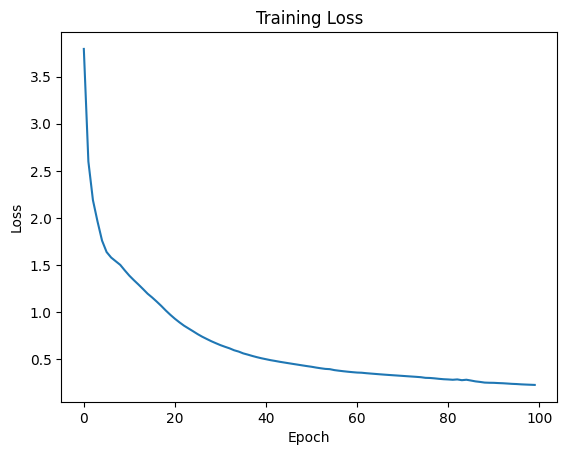

Model saved to models/gcn_2l_node.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.13GB
Average Memory Usage: 2.81GB

Total Training Time: 1.29s
Max CPU Usage: 2.86GB
Max Memory Usage: 2.83GB


In [23]:
gcn2_node = GCN2Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
print(gcn2_node)
print(f"Total number of trainable parameters: {gcn2_node.count_parameters()}\n")
train_node(gcn2_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcn_2l_node.pth')

### GCESN

#### Variant 1

GCESN(
  (fc): Linear(in_features=1433, out_features=7, bias=True)
)
Total number of trainable parameters: 10038

Epoch 1, Loss: 4.440561771392822
Time: 0.15s, CPU: 1.48GB, Memory: 2.83GB
Epoch 2, Loss: 5.486979961395264
Time: 0.15s, CPU: 1.93GB, Memory: 2.83GB
Epoch 3, Loss: 13.739534378051758
Time: 0.15s, CPU: 1.84GB, Memory: 2.82GB
Epoch 4, Loss: 16.88147735595703
Time: 0.15s, CPU: 2.71GB, Memory: 2.82GB
Epoch 5, Loss: 18.30681610107422
Time: 0.15s, CPU: 2.10GB, Memory: 2.82GB
Epoch 6, Loss: 16.426950454711914
Time: 0.15s, CPU: 1.91GB, Memory: 2.82GB
Epoch 7, Loss: 13.537982940673828
Time: 0.15s, CPU: 1.84GB, Memory: 2.82GB
Epoch 8, Loss: 11.303751945495605
Time: 0.15s, CPU: 1.69GB, Memory: 2.81GB
Epoch 9, Loss: 11.997872352600098
Time: 0.15s, CPU: 1.85GB, Memory: 2.81GB
Epoch 10, Loss: 9.87040901184082
Time: 0.15s, CPU: 1.78GB, Memory: 2.81GB
Epoch 11, Loss: 8.868487358093262
Time: 0.15s, CPU: 1.85GB, Memory: 2.81GB
Epoch 12, Loss: 9.242960929870605
Time: 0.15s, CPU: 1.75GB, Memory

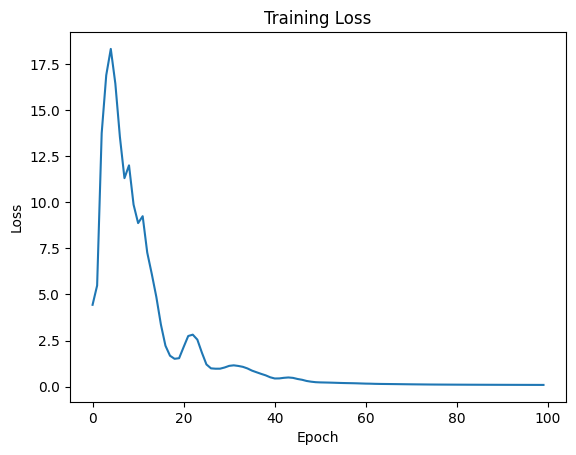

Model saved to models/gcesn_v1_node.pth
Average Time per Epoch: 0.15s
Average CPU Usage: 1.64GB
Average Memory Usage: 2.82GB

Total Training Time: 14.94s
Max CPU Usage: 3.10GB
Max Memory Usage: 2.87GB


In [24]:
# Create model instances
num_features = cora_dataset.num_node_features
gcesn1_node = GCESN_var1(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
print(gcesn1_node)
print(f"Total number of trainable parameters: {gcesn1_node.count_parameters()}\n")
train_node(gcesn1_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcesn_v1_node.pth')

#### variant 2

GCESN_var2(
  (fc): Linear(in_features=1433, out_features=7, bias=True)
)
Total number of trainable parameters: 10038

Epoch 1, Loss: 0.0991176888346672
Time: 0.17s, CPU: 0.82GB, Memory: 2.81GB
Epoch 2, Loss: 1.7817031145095825
Time: 0.15s, CPU: 1.98GB, Memory: 2.82GB
Epoch 3, Loss: 2.88757586479187
Time: 0.15s, CPU: 1.80GB, Memory: 2.82GB
Epoch 4, Loss: 1.041684627532959
Time: 0.15s, CPU: 2.38GB, Memory: 2.81GB
Epoch 5, Loss: 4.045085430145264
Time: 0.15s, CPU: 1.74GB, Memory: 2.81GB
Epoch 6, Loss: 0.8575098514556885
Time: 0.15s, CPU: 2.05GB, Memory: 2.81GB
Epoch 7, Loss: 0.9863812327384949
Time: 0.15s, CPU: 1.91GB, Memory: 2.81GB
Epoch 8, Loss: 1.4769725799560547
Time: 0.15s, CPU: 2.10GB, Memory: 2.81GB
Epoch 9, Loss: 1.5604037046432495
Time: 0.15s, CPU: 1.74GB, Memory: 2.81GB
Epoch 10, Loss: 1.1984484195709229
Time: 0.15s, CPU: 2.00GB, Memory: 2.81GB
Epoch 11, Loss: 0.7802700400352478
Time: 0.15s, CPU: 1.68GB, Memory: 2.81GB
Epoch 12, Loss: 0.4583534896373749
Time: 0.15s, CPU: 2.56G

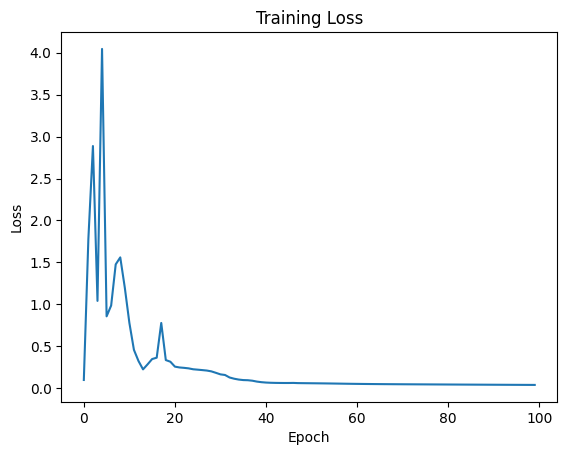

Model saved to models/gcesn_v2_node.pth
Average Time per Epoch: 0.16s
Average CPU Usage: 2.11GB
Average Memory Usage: 2.80GB

Total Training Time: 15.99s
Max CPU Usage: 5.82GB
Max Memory Usage: 2.87GB


In [26]:
# Create model instances
num_features = cora_dataset.num_node_features
gcesn2_node = GCESN_var2(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
print(gcesn2_node)
print(f"Total number of trainable parameters: {gcesn2_node.count_parameters()}\n")
train_node(gcesn1_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcesn_v2_node.pth')

### GCN-ESN

#### Variant 1

GCNESN_var1(
  (gcn1): GCN (1433 -> 1433)
  (fc): Linear(in_features=1433, out_features=7, bias=True)
)
Total number of trainable parameters: 2064960

Epoch 1, Loss: 1.9456621408462524
Time: 0.18s, CPU: 0.94GB, Memory: 2.56GB
Epoch 2, Loss: 0.8110384345054626
Time: 0.15s, CPU: 2.83GB, Memory: 2.53GB
Epoch 3, Loss: 0.6421992182731628
Time: 0.15s, CPU: 0.00GB, Memory: 2.54GB
Epoch 4, Loss: 0.11284331977367401
Time: 0.25s, CPU: 0.00GB, Memory: 2.54GB
Epoch 5, Loss: 0.05382377281785011
Time: 0.16s, CPU: 0.00GB, Memory: 2.54GB
Epoch 6, Loss: 0.03339963033795357
Time: 0.15s, CPU: 0.00GB, Memory: 2.54GB
Epoch 7, Loss: 0.016307096928358078
Time: 0.14s, CPU: 0.00GB, Memory: 2.54GB
Epoch 8, Loss: 0.009639482945203781
Time: 0.15s, CPU: 2.91GB, Memory: 2.54GB
Epoch 9, Loss: 0.005962234456092119
Time: 0.15s, CPU: 2.76GB, Memory: 2.50GB
Epoch 10, Loss: 0.003827214241027832
Time: 0.15s, CPU: 2.33GB, Memory: 2.51GB
Epoch 11, Loss: 0.002469645580276847
Time: 0.15s, CPU: 2.33GB, Memory: 2.51GB
Epoch 12,

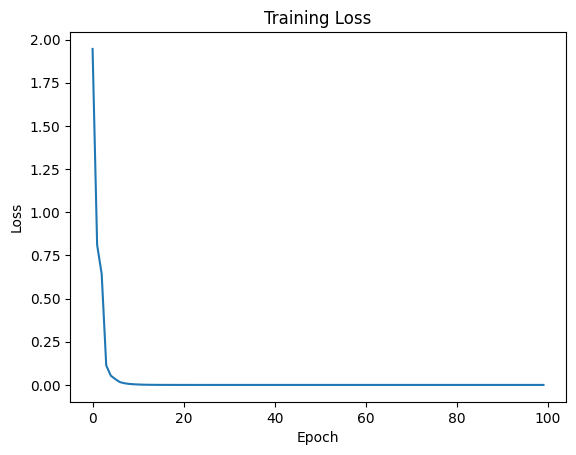

Model saved to models/gcnesn_v1_node.pth
Average Time per Epoch: 0.15s
Average CPU Usage: 1.64GB
Average Memory Usage: 2.52GB

Total Training Time: 14.81s
Max CPU Usage: 4.86GB
Max Memory Usage: 2.56GB


In [33]:
# Create model instances
num_features = cora_dataset.num_node_features
gcnesn1_node = GCNESN_var1(num_features, num_features, cora_dataset.num_classes)
print(gcnesn1_node)
print(f"Total number of trainable parameters: {gcnesn1_node.count_parameters()}\n")
train_node(gcnesn1_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcnesn_v1_node.pth')

GCNESN_var2(
  (gcn1): GCN (1433 -> 1433)
  (gcn2): GCN (1433 -> 1433)
  (fc): Linear(in_features=1433, out_features=7, bias=True)
)
Total number of trainable parameters: 4119882

Epoch 1, Loss: 2.378185272216797
Time: 0.38s, CPU: 1.02GB, Memory: 2.47GB
Epoch 2, Loss: 92.68260192871094
Time: 0.33s, CPU: 2.66GB, Memory: 2.48GB
Epoch 3, Loss: 75.17005920410156
Time: 0.32s, CPU: 2.38GB, Memory: 2.49GB
Epoch 4, Loss: 58.026248931884766
Time: 0.32s, CPU: 2.21GB, Memory: 2.47GB
Epoch 5, Loss: 37.52593231201172
Time: 0.32s, CPU: 2.28GB, Memory: 2.48GB
Epoch 6, Loss: 38.10976028442383
Time: 0.33s, CPU: 2.44GB, Memory: 2.48GB
Epoch 7, Loss: 40.11174774169922
Time: 0.32s, CPU: 2.26GB, Memory: 2.49GB
Epoch 8, Loss: 32.116050720214844
Time: 0.32s, CPU: 2.38GB, Memory: 2.45GB
Epoch 9, Loss: 16.19375228881836
Time: 0.32s, CPU: 2.45GB, Memory: 2.47GB
Epoch 10, Loss: 14.885173797607422
Time: 0.32s, CPU: 2.22GB, Memory: 2.48GB
Epoch 11, Loss: 15.761417388916016
Time: 0.32s, CPU: 2.76GB, Memory: 2.48GB


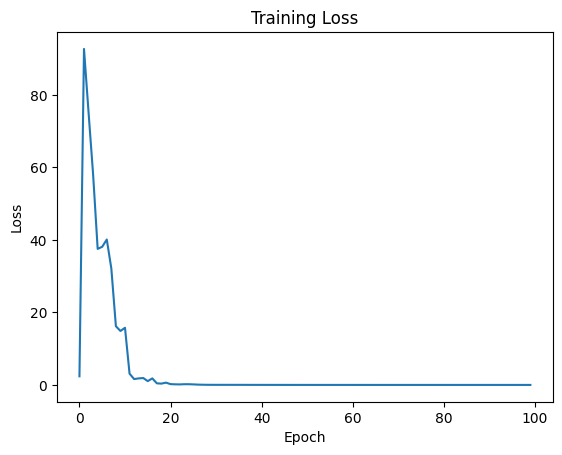

Model saved to models/gcnesn_v2_node.pth
Average Time per Epoch: 0.33s
Average CPU Usage: 2.30GB
Average Memory Usage: 2.48GB

Total Training Time: 32.77s
Max CPU Usage: 4.70GB
Max Memory Usage: 2.52GB


In [34]:
# Create model instances
num_features = cora_dataset.num_node_features
gcnesn2_node = GCNESN_var2(num_features, num_features, cora_dataset.num_classes)
print(gcnesn2_node)
print(f"Total number of trainable parameters: {gcnesn2_node.count_parameters()}\n")
train_node(gcnesn2_node, cora_data, lr=0.01, num_epochs=100, save_path='models/gcnesn_v2_node.pth')

## Evaluation

In [35]:
print('Model 1-Layer GCN')
gcn1_node = GCN1Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
gcn1_node.load_state_dict(torch.load('models/gcn_1l_node.pth'))
test_node(gcn1_node, cora_data, cora_data.test_mask)

print('\nModel 2-Layer GCN')
gcn2_node = GCN2Layer(num_features=cora_dataset.num_node_features, num_classes=cora_dataset.num_classes)
gcn2_node.load_state_dict(torch.load('models/gcn_2l_node.pth'))
test_node(gcn2_node, cora_data, cora_data.test_mask)

num_features = cora_dataset.num_node_features
print('\nModel GCESN Var-1')
gcesn1_node = GCESN_var1(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
gcesn1_node.load_state_dict(torch.load('models/gcesn_v1_node.pth'))
test_node(gcesn1_node, cora_data, cora_data.test_mask)

print('\nModel GCESN Var-2')
gcesn2_node = GCESN_var2(num_features, num_features, cora_dataset.num_classes, num_iterations=3)
gcesn2_node.load_state_dict(torch.load('models/gcesn_v2_node.pth'))
test_node(gcesn2_node, cora_data, cora_data.test_mask)

print('\nModel GCN-ESN Var-1')
gcnesn1_node = GCNESN_var1(num_features, num_features, cora_dataset.num_classes)
gcnesn1_node.load_state_dict(torch.load('models/gcnesn_v1_node.pth'))
test_node(gcnesn1_node, cora_data, cora_data.test_mask)

print('\nModel GCN-ESN Var-2')
gcnesn2_node = GCNESN_var2(num_features, num_features, cora_dataset.num_classes)
gcnesn2_node.load_state_dict(torch.load('models/gcnesn_v2_node.pth'))
test_node(gcnesn2_node, cora_data, cora_data.test_mask)

Model 1-Layer GCN
Accuracy: 0.9314
Sensitivity: 0.9200
Specificity: 0.9400

Model 2-Layer GCN
Accuracy: 0.9412
Sensitivity: 0.9855
Specificity: 0.8955

Model GCESN Var-1
Accuracy: 0.9586
Sensitivity: 0.9589
Specificity: 0.9583

Model GCESN Var-2
Accuracy: 0.9704
Sensitivity: 0.9726
Specificity: 0.9688

Model GCN-ESN Var-1
Accuracy: 0.9365
Sensitivity: 0.9167
Specificity: 0.9524

Model GCN-ESN Var-2
Accuracy: 0.9532
Sensitivity: 0.9506
Specificity: 0.9556
